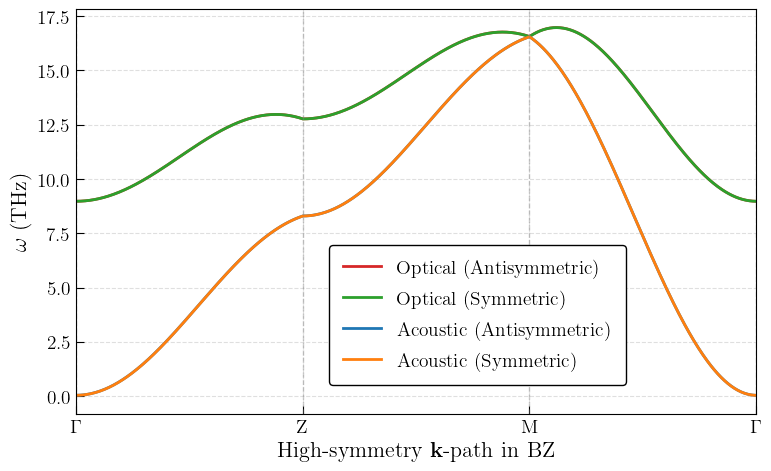

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 16,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

# Parameters
a = 3.54  # Amstrong (y-axis)
b = 4.73  # Amstrong (z-axis)
S = 3/2
Da = 0.2418*2*0.012 # D_X TUELING (I KNOW IT'S CHANGED, THEY HAVE DIFFERENT AXIS)
Dc = 0.2418*2*0.078 # D_Y TUELING (I KNOW IT'S CHANGED, THEY HAVE DIFFERENT AXIS)

B_T = 0.4 # External Field in Teslas (PARAMETER)
g=2 # g-factor for Cr^3+ (S=3/2 & L=0) is 2 exactly!
mu_B = 0.2418* 0.05788  # Bohr magneton in GHz/T
B = g * mu_B * B_T  # Convert to GHz (THIS IS B FROM THE HAMILTONIAN)

delta_c = 0.2  # Assume negligible for 2D plot
J_AB = 0.2418* 3.08 # J_2 EN TUELING
J_AA = 0.2418* 4.15  # J_3 EN TUELING
J_AA_T = 0.2418* 0.0155
J_AB_T = J_AA_T
z = 4  # coordination number

theta_deg = 1.0  # Rotation angle in degrees
theta = np.radians(theta_deg)  # Convert to radians

# Ángulo de canting o saturación
threshold = (Da*np.cos(theta)*(2*S-1)/2 + 2*S*(J_AA_T+J_AB_T))
if B < threshold:
    sin_chi = B / threshold
    chi = np.arcsin(sin_chi)
else:
    chi = np.pi / 2

# Reciprocal lattice vectors for rectangular lattice
G_y = 2 * np.pi / a
G_z = 2 * np.pi / b

# High-symmetry points
Gamma = np.array([0,0, 0])
Z = np.array([0,0, G_z / 2])
M = np.array([0,G_y / 2, G_z / 2])

# Path: Γ → Z → M → Γ
path = [Gamma, Z, M, Gamma]
labels = [r'$\Gamma$', 'Z', 'M', r'$\Gamma$']

# Interpolation of k-points
num_points = 200
k_points = []
segment_lengths = [0]
for i in range(len(path) - 1):
    start, end = path[i], path[i + 1]
    segment = np.linspace(start, end, num_points, endpoint=False)
    k_points.append(segment)
    segment_lengths.append(segment_lengths[-1] + np.linalg.norm(end - start))
k_points = np.concatenate(k_points)

def gamma_AA(k):
    return 2 * (np.cos(a * k[1]) + np.cos(b * k[2]))

def gamma_BB(k):
    return 2 * np.exp(1j * delta_c * k[0]) * (np.cos(a * k[1]) + np.cos(b * k[2]))

def gamma_AB(k):
    return np.exp(1j * delta_c * k[0]) * 2 * (np.cos(a * k[1] / 2) + np.cos(b * k[2] / 2))

# Coeficientes FERRO
def d_AA(k):
    return -J_AA*S*((gamma_AA(k)+gamma_AA(-k))/2 - z) + J_AB*S*z

def d_BB(k):
    return -J_AA*S*((gamma_BB(k)+gamma_BB(-k))/2 - z) + J_AB*S*z

def d_AB(k):
    return -J_AB*S*gamma_AB(k)

#Coeficientes \hat{a} ANISOTROPY
d_a = Da * (S*np.cos(chi+theta/2)*np.cos(chi+theta/2) - (2*S-1)*np.sin(chi+theta/2)*np.sin(chi+theta/2))
o_a = -Da*S*np.cos(chi+theta/2)*np.cos(chi+theta/2)/4

#Coeficientes \hat{c} ANISOTROPY
d_c = Dc*S/2
o_c = Dc*S/4

#Coeficientes EXTERNAL FIELD
d_B = B * np.sin(chi)

#Coeficientes INTERLAYER COUPLING
d_AA_T=J_AA_T*S*np.cos(2*chi)

def d_AB_T(k):
    return J_AB_T*S*np.cos(2*chi) * (np.exp(1j * (k[0]*delta_c+k[1]*a/2 + k[2]*b/2)))

def h_AB_adb_T(k): 
    return J_AB_T*S*(1-np.cos(2*chi))*np.exp(1j * (k[0]*delta_c+k[1]*a/2 + k[2]*b/2))/2

def h_AB_ab_T(k):
    return J_AB_T*S*(1+np.cos(2*chi))*np.exp(1j * (k[0]*delta_c+k[1]*a/2 + k[2]*b/2))/2

h_AA_adb_T = J_AA_T*S*(1-np.cos(2*chi))/2
h_AA_ab_T = J_AA_T*S*(1+np.cos(2*chi))/2

# Coefficients for the BdG Hamiltonian
def h_AA_d(k):
    return d_AA(k) + d_a + d_c + d_B + d_AA_T
def h_BB_d(k):
    return d_BB(k) + d_a + d_c + d_B + d_AA_T
h_AA_aa = o_a + o_c
h_AA_adb = h_AA_adb_T
h_AA_ab = h_AA_ab_T

def h_AB_d(k):
    return d_AB(k) + d_AB_T(k)
def h_AB_adb(k):
    return h_AB_adb_T(k)
def h_AB_ab(k):
    return h_AB_ab_T(k)

# Function to compute BdG Hamiltonian and diagonalize SH
def bdg_eigenvalues(k):
    H = np.array([
        [h_AA_d(k), h_AA_aa, h_AA_adb, h_AA_ab, h_AB_d(k), 0, h_AB_adb(k), h_AB_ab(k)],
        [h_AA_aa, h_AA_d(k), h_AA_ab, h_AA_adb, 0, h_AB_d(k), h_AB_ab(k), h_AB_adb(k)],
        [h_AA_adb, h_AA_ab, h_AA_d(k), h_AA_aa, h_AB_adb(k), h_AB_ab(k), h_AB_d(k), 0],
        [h_AA_ab, h_AA_adb, h_AA_aa, h_AA_d(k), h_AB_ab(k), h_AB_adb(k), 0, h_AB_d(k)],
        [h_AB_d(-k), 0, h_AB_adb(-k), h_AB_ab(-k), h_BB_d(k), h_AA_aa, h_AA_adb, h_AA_ab],
        [0, h_AB_d(-k), h_AB_ab(-k), h_AB_adb(-k), h_AA_aa, h_BB_d(k), h_AA_ab, h_AA_adb],
        [h_AB_adb(-k), h_AB_ab(-k), h_AB_d(-k), 0, h_AA_adb, h_AA_ab, h_BB_d(k), h_AA_aa],
        [h_AB_ab(-k), h_AB_adb(-k), 0, h_AB_d(-k), h_AA_ab, h_AA_adb, h_AA_aa, h_BB_d(k)]
    ])
    S_mat = np.diag([1, -1, 1, -1, 1, -1, 1, -1])
    
    eigvals = np.linalg.eigvals(S_mat @ H)
    eigvals = np.real(eigvals)
    eigvals = np.sort(eigvals)[::-1]  # Descending
    return eigvals[:4]  # Only positive-energy branches if needed

# Compute band structure
bands = np.array([bdg_eigenvalues(k) for k in k_points])

# === Plotting Style ===
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 16,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

# === Band Structure Plot ===
fig, ax = plt.subplots(figsize=(8, 5))

# Colors for bands
colors = ['#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']
labels_band = [
    r'Optical (Antisymmetric)',
    r'Optical (Symmetric)',
    r'Acoustic (Antisymmetric)',
    r'Acoustic (Symmetric)'
]

# Plot bands and build legend handles
legend_elements = []
for i in range(bands.shape[1]):
    ax.plot(bands[:, i], color=colors[i], linewidth=2)
    legend_elements.append(Line2D([0], [0], color=colors[i], lw=2, label=labels_band[i]))

# High-symmetry vertical lines
for x in [0, num_points, 2*num_points, 3*num_points]:
    ax.axvline(x, color='gray', linestyle='--', linewidth=1, alpha=0.4)

# X-axis: symmetry points
ax.set_xticks([0, num_points, 2*num_points, 3*num_points])
ax.set_xticklabels([r'$\Gamma$', 'Z', 'M', r'$\Gamma$'])
ax.set_xlim(0, 3 * num_points)

# Axes labels and title
ax.set_xlabel(r'High-symmetry $\mathbf{k}$-path in BZ')
ax.set_ylabel(r'$\omega$ (THz)')

# Legend in white box, top left
ax.legend(handles=legend_elements,
          loc='lower center',
          bbox_to_anchor=(0.59, 0.048),
          frameon=True,
          framealpha=1,
          edgecolor='black',
          handlelength=2,
          handletextpad=0.8,
          borderpad=0.7,
          labelspacing=0.6)

# Grid and styling
ax.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(direction='in', length=6)
plt.tight_layout()

# === Save as vector figure ===
plt.savefig("magnon_band_structure__.svg", format='svg', bbox_inches='tight')
plt.show()


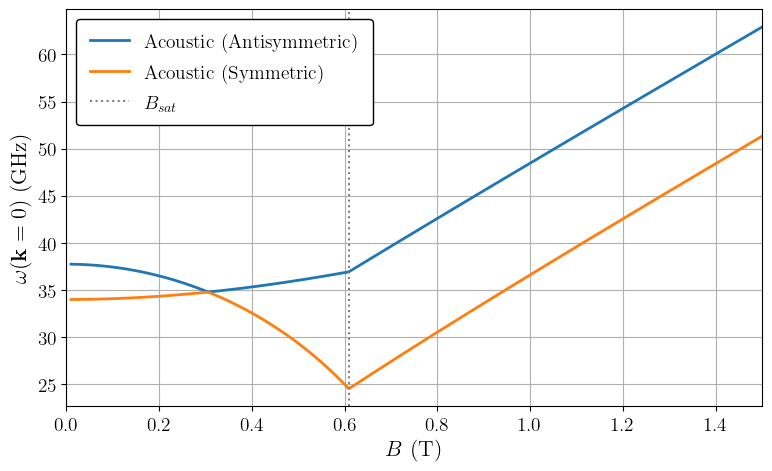

0.6090186592950932


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = 3.54
b = 4.73
S = 3/2
Da = 241.8 * 2*0.012
Dc = 241.8 * 2*0.078
delta_c = 0
g=2 # g-factor for Cr^3+ (S=3/2 & L=0) is 2 exactly!
mu_B = 241.8 * 0.05788  # Bohr magneton in GHz/T
J_AB = 0
J_AA = 241.8 * 4.15
J_AA_T = 241.8 * 0.0155
J_AB_T = 0
z = 4
theta_deg = 0
theta = np.radians(theta_deg)
G_y = 2 * np.pi / a
G_z = 2 * np.pi / b

# Define gamma functions
def gamma_AA(k):
    return 2 * (np.cos(a * k[1]) + np.cos(b * k[2]))

# Ferro coefficients
def d_AA(k): return -J_AA*S*(gamma_AA(k) - z) + J_AB*S*z


threshold = (Da*np.cos(theta)*(2*S-1)/2 + 2*S*(J_AA_T))
def bdg_eigenvalues_k0(B_T_val):
    B = g * mu_B  * B_T_val
    chi = np.arcsin(B / threshold) if B < threshold else np.pi / 2
    k = np.array([0, 0, 0])
    
    # Anisotropy and interlayer coefficients
    d_a = Da * (S*np.cos(chi+theta/2)**2 - (2*S-1)*np.sin(chi+theta/2)**2) /2
    o_a = -Da*S*np.cos(chi+theta/2)**2/4
    d_c = Dc*S/2
    o_c = Dc*S/4
    d_B = B * np.sin(chi)
    d_AA_T = J_AA_T*S*np.cos(2*chi)

    h_AA_adb_T = J_AA_T*S*(1-np.cos(2*chi))/2
    h_AA_ab_T = J_AA_T*S*(1+np.cos(2*chi))/2

    def h_AA_d(k): return d_AA(k) + d_a + d_c + d_B + d_AA_T
    h_AA_aa = o_a + o_c
    h_AA_adb = h_AA_adb_T
    h_AA_ab = h_AA_ab_T

    H = np.array([
        [h_AA_d(k), h_AA_aa, h_AA_adb, h_AA_ab],
        [h_AA_aa, h_AA_d(k), h_AA_ab, h_AA_adb],
        [h_AA_adb, h_AA_ab, h_AA_d(k), h_AA_aa],
        [h_AA_ab, h_AA_adb, h_AA_aa, h_AA_d(k)]
    ])
    S_mat = np.diag([1, -1, 1, -1])
    eigvals = np.linalg.eigvals(S_mat @ H)
    eigvals = np.real(eigvals)
    eigvals = np.sort(eigvals)[::-1]
    return eigvals[:2]

# Sweep field B_T and compute bands at k = 0
B_T_vals = np.linspace(0.01, 1.5, 300)
bands_vs_B = np.array([bdg_eigenvalues_k0(BT) for BT in B_T_vals])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(B_T_vals, bands_vs_B[:, 0], label=f'Acoustic (Antisymmetric)', color='#1f77b4', linewidth=2)
plt.plot(B_T_vals, bands_vs_B[:, 1], label=f'Acoustic (Symmetric)', color='#ff7f0e', linewidth=2)
plt.axvline(threshold/(g *mu_B), color='gray', linestyle=':', label=r'$B_{sat}$')
plt.xlabel('$B$ (T)')
plt.ylabel('$\omega(\mathbf{k}=0)$ (GHz)')
plt.xlim(0,1.5)
plt.grid(True)
# Custom legend with white box and detailed spacing
plt.legend(
    loc='upper left',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    handlelength=2,
    handletextpad=0.8,
    borderpad=0.7,
    labelspacing=0.6
)

plt.tight_layout()


plt.savefig("UNROTATED_OMEGAVSB.svg", format='svg', bbox_inches='tight')
plt.show()